## Implementing a Multi-layer Perceptron (MLP)

In the previous notebooks we introduced the bigram model which, for a bigram `XY`, gives the probability for each character `Y` given `X` precedes it. 
We took two approaches to learn these probabilities using a dataset of English names:
1. Count the occurrence of all possible bigrams within the dataset, then normalize these counts into a probability distribution.
2. Phrase the question as a supervised learning problem:
- For each bigram `XY` in our dataset create an input/output pair `(x,y)` to learn predict character `y` given `x`.
- Define a matrix of model parameters (weights.) Embed our inputs using a one-hot vector, multiply this vector by our weights, then apply the softmax function to the products to generate a probability distribution.
- Use the negative log-likelihood (NLL) function to define the loss between what character our model predicts and what character was actually observed.
- Use backpropagation to update our weights such that we minimize our lost.
- Iteratively repeat apply other bigrams to our model to update it.

We found that the model we learned was really learning the model resulting from our occurrence counts. 
However that there were drawbacks with the bigram model: 
1. When generating names using our model, the names weren't the best (i.e. not all seemed like real names.) One approach we proposed was to use a larger *context window* like a 3-gram, 4-gram, or so on.
2. As we generalize to an n-gram the size of the matrix we would need to track our occurrence counts would be of size $|A|^n$ where $|A|$ is the size of our alphabet. These parameters grow exponentially with the size of our context window.

These two points lead to what is covered in this notebook: implementing a multi-layer perceptron to learn probabilities associated with a larger context window than one.

To begin, let's run some code we covered last time to load the dataset and build a vocabulary of characters.

In [1]:
# import packages
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt 
%matplotlib inline
# read datasets
fp = "../.data/nlp/"
data = open(f'{fp}training_corpus.txt', 'r').read().splitlines()

# string of all 26 characters sorted a to z. Works as all characters appear in training set.
chars = sorted(list(set(''.join(data))))
# mapping of characters to index.
idx_to_char = {}
char_to_idx = {}
char_to_idx['.'] = 0
for i,c in enumerate(chars):
    char_to_idx[c] = i+1
# create reverse mapping for use when plotting. 
idx_to_char = {i:c for c,i in char_to_idx.items()}

Let's build our supervised dataset using a specific `context_window` size. 
Suppose we use a window size of 3. 
For each word in our dataset, we can generate a pair on input/output data for each character (plus one - the ending character.)
Consider the name "iroh". We have the following (x,y) pairs:
- ('...', 'i')
- ('..i', 'r')
- ('.ir', 'o')
- ('iro', 'h')
- ('roh', '.')
  
Similar to the previous notebook we don't use the characters within the pairs. 
Instead we store the indices:
- ([0,0,0], 9)
- ([0,0,9], 18)
- ([0,9,18], 15)
- ([9,18,15], 8)
- ([18,15,8], 0)


In [2]:
context_window = 3
def build_dataset(dataset):
    X, Y = [], []
    for w in dataset:
        # start with the first context window. All values will be 0 - the index for '.'
        context = [0] * context_window
        # print("word:", w)
        for ch in w + ".":
            idx = char_to_idx[ch]
            # X is a list of lists (of indices)
            X.append(context)
            # Y is a list of indices
            Y.append(idx)
            # print(''.join(idx_to_char[i] for i in context), '-->', idx_to_char[idx])
            context = context[1:] + [idx]
    # convert to tensors
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X,Y

### Train, test, and validation sets 

While training neural nets a concern is over fitting to the training data set.
This occurs when we update our model parameters such that it starts to *memorize* the training data instead of learning the true underlying distribution. 
We can monitor if our model starts to over fit by making use of a test set while training. 

We partition our available data into 3 sets:
1. training set: used to update our model's parameters during forward/backward passes.
2. test set: used every X training iterations to compute our loss.
3. validation set: used after training to see how our model fares on new, unseen data.

During training, if we observe an increase in the test set's loss while our training set's loss decreases, this is a sign of over fitting. 

In [3]:
# shuffle the data set 
import random
random.seed(31)
random.shuffle(data)
# partition training set into training and test sets.
# use 90% / 10% split
X_train, Y_train = build_dataset(data[:int(0.9*len(data))])
X_test, Y_test = build_dataset(data[int(0.9*len(data)):])


### Defining the MLP

We now define our MLP architecture. 
This follows from the architecture proposed in the paper [A Neural Probabilistic Language Model - Bengio et. al 2003](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf).

- In our first layer we have 27 inputs - one for each character. Instead of using a one-hot encoding as we did previously, we use 
-  We label this embedding as $C$ of size $R^{28 \times 10}$. Note this is equivalent to using our one-hot encoding previously.
- In our second layer we use both a weight matrix $W1$ and bias vector $b1$ of size $R^{10 \times 200}$ and $R^{200}$ respectively. Using the output of our first layer, we multiply it by $W1$ and add $b1$ then apply this result to a non-linear function $tanh$ which is fed into the next layer.
- For our third and final layer, we use both a weight matrix $W2$ and $b2$ in a similar fashion as before on the output from the second layer to generate our logits which we can use in our softmax to produce probabilities.

Below we randomly initialize the parameters.


In [4]:
g = torch.Generator().manual_seed(892347120)

C = torch.randn((27,10), generator=g)
W1 = torch.randn((30, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100,27), generator=g)
b2 = torch.randn(27, generator=g)
params = [C, W1, b1, W2, b2]
print("Num of params: ", sum([p.nelement() for p in params]))

Num of params:  6097


In [5]:
for p in params:
  p.requires_grad = True

In [6]:
# track loss at each iteration
train_losses = []
test_losses = []
train_indices = []
test_indices = []
for i in range (50_000):
    # generate minibatch from training data
    minibatch_size = 32
    idxs = torch.randint(0, X_train.shape[0], (minibatch_size,))
    # Forward pass
    embed = C[X_train[idxs]]
    o1 = torch.tanh(embed.view(-1, 30) @ W1 + b1)
    logits = o1 @ W2 + b2
    loss = F.cross_entropy(logits, Y_train[idxs])
    
    # zero gradients (set to None)
    for p in params:
        p.grad = None
        
    # Backwards pass
    loss.backward()
    lr = 0.05 if i < 10_000 else 0.001
    for p in params:
        p.data += -lr * p.grad

    if (i+1) % 1000 == 0:
        # Compute test set loss
        with torch.no_grad():
            test_embed = C[X_test]
            test_o1 = torch.tanh(test_embed.view(-1, 30) @ W1 + b1)
            test_logits = test_o1 @ W2 + b2
            test_loss = F.cross_entropy(test_logits, Y_test)
            print (f'{i+1}: training loss: {loss} test loss: {test_loss}')
            test_losses.append(test_loss.item())
            test_indices.append(i)
    # track stats
    train_indices.append(i)
    train_losses.append(loss.item())
    

1000: training loss: 4.748668670654297 test loss: 4.318130016326904
2000: training loss: 3.1869943141937256 test loss: 3.388385534286499
3000: training loss: 2.6679892539978027 test loss: 2.9342215061187744
4000: training loss: 2.4021520614624023 test loss: 2.768754005432129
5000: training loss: 3.3020670413970947 test loss: 2.6243107318878174
6000: training loss: 2.6068615913391113 test loss: 2.5671379566192627
7000: training loss: 2.6879258155822754 test loss: 2.530409097671509
8000: training loss: 2.4162323474884033 test loss: 2.5195417404174805
9000: training loss: 2.475687265396118 test loss: 2.496870279312134
10000: training loss: 2.8194658756256104 test loss: 2.4726407527923584
11000: training loss: 2.3639302253723145 test loss: 2.41667103767395
12000: training loss: 2.4001500606536865 test loss: 2.4051053524017334
13000: training loss: 2.811002016067505 test loss: 2.40104341506958
14000: training loss: 2.359405755996704 test loss: 2.3976593017578125
15000: training loss: 2.5949

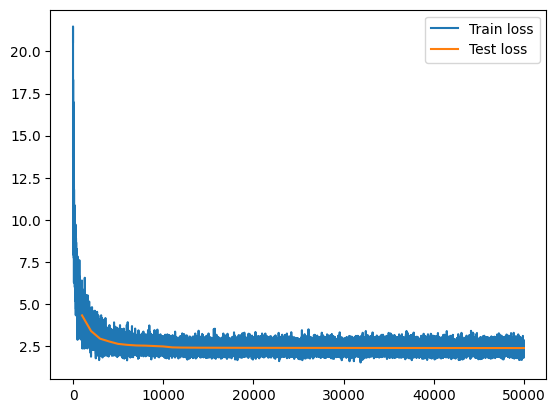

In [7]:
# plot loss vs. iterations
plt.plot(train_indices, train_losses, label="Train loss")
plt.plot(test_indices, test_losses, label="Test loss")
plt.legend()
plt.show()

We plot our train and test losses vs. the number of training iterations. 
We see that both our training and test losses decrease (as opposed to training decreasing but test loss increasing - a sign of overfitting to our training data.)

Let's now see what kind of names our model generates!

In [17]:
g = torch.Generator().manual_seed(892347120)

# sample from the model
for _ in range(20):
    out = []
    context = [0] * context_window
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        idx = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [idx]
        out.append(idx_to_char[idx])
        if idx == 0:
            break
    name = ''.join(out)
    print(f"Name: '{name}'. Name is in training set? {name in data}")

Name: 'libiialind.'. Name is in training set? False
Name: 'reeco.'. Name is in training set? False
Name: 'amir.'. Name is in training set? False
Name: 'rophen.'. Name is in training set? False
Name: 'many.'. Name is in training set? False
Name: 'yuzann.'. Name is in training set? False
Name: 'tila.'. Name is in training set? False
Name: 'sherte.'. Name is in training set? False
Name: 'dandie.'. Name is in training set? False
Name: 'nirec.'. Name is in training set? False
Name: 'zlo.'. Name is in training set? False
Name: 'mairqua.'. Name is in training set? False
Name: 'metseryo.'. Name is in training set? False
Name: 'nasvalphila.'. Name is in training set? False
Name: 'cla.'. Name is in training set? False
Name: 'tus.'. Name is in training set? False
Name: 'shelmyndriseka.'. Name is in training set? False
Name: 'yqucavonn.'. Name is in training set? False
Name: 'iameshpi.'. Name is in training set? False
Name: 'bet.'. Name is in training set? False


We first notice all names generated by our model are not within our training dataset. 
This is good as otherwise our model may have over-fitted to our training data. 
Next the names generated above like "reeco", "amir", or "tila" do seem like plausible names. 
Further our model has generated actual words like "many" and "bet". 
Yet outputs like "yqucavonn" or "yqucavonn" seem less likely for names. 